# What's that Doggy in the Window?
## Image Classification

By: **Bryan Santos**

Have you ever wanted to know the breed of dogs you see in social media or in parks because you found they look suitable for yourself?

This project aims to build an application that lets users upload images of a dog and get its breed. The application will then assess the breed characteristics if it is suitable for the user based on lifestyle. If it is, then the system will redirect the user to a dog of that particular breed that is up for adoption.

The project will utilize multi-class image classification and recommendation systems machine learning models to achieve its goals.

The pet industry is a multi-billion dollar industry even just in the United States alone. The trend of owning pets is on a steady rise. Unfortunately, so do the number of dogs that would be without a permanent home or that would be euthanized. Many people buy dogs because of fad or appearances and abandon them, most likely because they do not realize that dogs of different breeds have unique characteristics and may not necessarily match their lifestyles.

***

This notebook tackles the multi-class image classification objective of this project. The aim is to be able to predict dog breeds based solely on dog images as accurately as possible.

Then plan is to create the following models:
* Baseline model (using Dummy Classifier)
* Model made from scratch 
* Re-using transfer learning, pre-trained models

We have 28,000+ images which means training models on such amount of datasets might bring computational efficiency problems. Hence, we will be using Google Colab to take advantage of its GPU performance.

## 1: Package Imports and Data Load

Below are the necessary packages to be able to classify dog breeds solely based on dog images. This involves basic packages such as pandas and numpy, but also deep learning imports such as tensorflow and keras.

In [64]:
### Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns
%matplotlib inline 
sns.set()

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.datasets import load_files       
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import confusion_matrix

from IPython.display import Image
import os
import glob
from glob import glob
from tqdm import tqdm
import cv2
import PIL
from PIL import ImageFile
import datetime
import itertools

import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions 
from keras.preprocessing import image        

We need to ensure we are using Colab's GPU for faster performance. By default, Google Colab runs on a computer without GPU.

In [2]:
### Check for GPU availability
if tf.config.list_physical_devices('GPU'):
  print("GPU is available.")
else:
  print("GPU is NOT available.")

GPU is NOT available.


In [33]:
### Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("targets_df.csv", index_col = 0)
print(labels_csv.describe())
print(labels_csv.head())

                        filename    breed
count                      28666    28666
unique                     28666      173
top     dtrvnk054ejufq98i2wo.jpg  maltese
freq                           1      312
                   filename    breed
0  m8045hqkl3wiado97pcb.jpg  maltese
1  51n7gcvmu9x2e8wfoql6.jpg  maltese
2  its279rcqnjuz6eao03w.jpg  maltese
3  mzhr9l61d3j4sqogbu5n.jpg  maltese
4  wurbzx6jnvgep8d4mao2.jpg  maltese


In [34]:
labels_csv.head(5)

,filename,breed
0,m8045hqkl3wiado97pcb.jpg,maltese
1,51n7gcvmu9x2e8wfoql6.jpg,maltese
2,its279rcqnjuz6eao03w.jpg,maltese
3,mzhr9l61d3j4sqogbu5n.jpg,maltese
4,wurbzx6jnvgep8d4mao2.jpg,maltese


***

## 2: Data Preparation

This sections contains the careful preparation to create machine learning models.

### Environment and Data Setup

In [ ]:
### Running this cell provided me with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### Uncompress files
#!unzip "drive/My Drive/Capstone/images.zip" -d "drive/My Drive/Capstone/images/"

I will only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much more efficient than working with images.

In [35]:
### Create pathnames from image filenames
filenames = ["images/train/" + fname for fname in labels_csv["filename"]]

### Check the first 10 filenames
filenames[:10]

['images/train/m8045hqkl3wiado97pcb.jpg',
 'images/train/51n7gcvmu9x2e8wfoql6.jpg',
 'images/train/its279rcqnjuz6eao03w.jpg',
 'images/train/mzhr9l61d3j4sqogbu5n.jpg',
 'images/train/wurbzx6jnvgep8d4mao2.jpg',
 'images/train/utfn8e90pmd4kqhwryia.jpg',
 'images/train/olb3uhx4m8ya1w97detk.jpg',
 'images/train/37jyl4harcxeqfbzv9tn.jpg',
 'images/train/p8w10ol6xdh3g2j7kas9.jpg',
 'images/train/60woienh34x5yzjt29gf.jpg']

### Getting Images and Labels

In [7]:
### Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("images/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


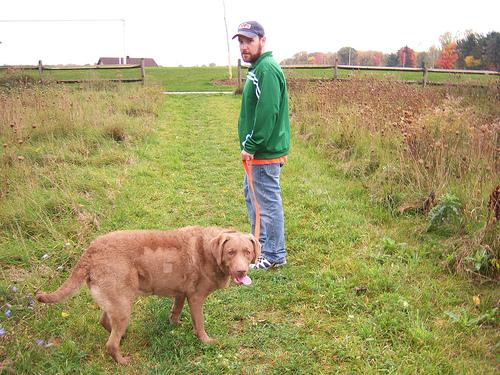

In [8]:
### Check an image directly from a filepath
Image(filenames[9000])

To get the labels, I need to convert them into a numpy array.

In [36]:
### Convert to Numpy Array
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['maltese', 'maltese', 'maltese', 'maltese', 'maltese', 'maltese',
       'maltese', 'maltese', 'maltese', 'maltese'], dtype=object)

Machine learning models is not able to accept strings as input. I will convert the labels into numbers.

In [37]:
### Find the unique label values and therefore the number of classes
unique_breeds = np.unique(labels)
len(unique_breeds)

173

In [38]:
### As validation, convert the most frequent breed into an array of booleans
print(labels[0])
labels[0] == unique_breeds

maltese


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [39]:
### Convert every label into boolean arrays
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [40]:
### One-hot encoding / categorical variable
print(labels[0])
print(np.where(unique_breeds == labels[0])[0][0]) 
print(boolean_labels[0].argmax()) 
print(boolean_labels[0].astype(int))

maltese
71
71
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Creating Validation Set

Usual practice is to split our training data into actual training and validation which is what I will be doing in this section.

In [41]:
### Setup features and targets
X = filenames
y = boolean_labels

In [42]:
### Set number of images to use for experimenting
NUM_IMAGES = 28666
NUM_IMAGES

28666

Split data 80:20.

In [43]:
### Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(22932, 22932, 5734, 5734)

In [20]:
### Validate the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['images/train/aubiv2r4m6y8z95qc0es.jpg',
  'images/train/kr2d04comisazqn9yfbv.jpg',
  'images/train/vp3n1xzek82rq6yct4ld.jpg',
  'images/train/5kfams98olnwyq6tjp10.jpg',
  'images/train/kx3572e4tghm16oaslpb.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,

The dataset to be split and loaded below will be used for the models that will be built from scratch.

In [94]:
### Load dataset for model to be built from scratch
def load_dataset(path):
    '''
    Loads the dataset. 
    
    Parameters:
    - path = images path
    
    Output:
    - Dataset for modeling from scratch
    
    '''
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 173)
    return dog_files, dog_targets

### Load train and validation datasets
train_files, train_targets = load_dataset('backup/2/images/train')
valid_files, valid_targets = load_dataset('backup/2/images/validation')
test_files, test_targets = load_dataset('backup/2/images/test')

### Load list of dog names
dog_names = [item for item in sorted(glob("backup/2/images/train/*/"))]

### Print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 173 total dog categories.
There are 28669 total dog images.

There are 18553 training dog images.
There are 4309 validation dog images.
There are 5807 test dog images.


In [65]:
### Analysis of the number of images in each class
globlist = list(glob("images/train/*/"))

###  Extract number of images per class
img_per_class = []
for folder in globlist:
    class_length = (len(folder))
    img_per_class.append(class_length)
print(img_per_class)

### Average number of images per class
print("mean:",np.mean(img_per_class))
print("max:" ,np.max(img_per_class))
print("min:" ,np.min(img_per_class))

[26, 30, 30, 24, 35, 28, 23, 30, 29, 27, 21, 31, 26, 24, 20, 30, 39, 24, 32, 22, 27, 28, 24, 23, 28, 30, 28, 28, 40, 35, 30, 32, 20, 33, 23, 25, 23, 33, 27, 21, 21, 29, 22, 23, 28, 27, 29, 35, 29, 19, 31, 33, 32, 33, 19, 28, 28, 36, 30, 26, 27, 23, 28, 35, 26, 26, 24, 34, 17, 30, 35, 28, 30, 22, 34, 33, 21, 21, 19, 22, 30, 20, 29, 27, 20, 31, 28, 20, 20, 28, 31, 30, 21, 27, 32, 31, 41, 26, 24, 27, 22, 27, 28, 25, 23, 24, 29, 26, 26, 29, 30, 21, 25, 20, 27, 29, 34, 32, 23, 25, 27, 31, 36, 19, 31, 32, 29, 25, 20, 32, 18, 19, 32, 23, 32, 29, 19, 24, 22, 30, 27, 34, 32, 30, 30, 32, 34, 21, 30, 30, 38, 44, 20, 26, 20, 30, 30, 25, 21, 34, 19, 29, 21, 34, 22, 21, 29, 19, 30, 21, 34, 36, 29]
mean: 27.352601156069365
max: 44
min: 17


### Turn Images into Tensors

The labels are in numeric format but our images are still just file paths. Since I will be using TensorFlow, the data has to be in the form of Tensors.

In [21]:
### Read an image
image = imread(filenames[42]) 
image.shape

(375, 500, 3)

The shape of each input has three values. Width, height, and color channel because our images are colored. Convert it to tensor like below.

In [22]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[162, 157, 154],
        [162, 157, 154],
        [162, 157, 154],
        ...,
        [136, 131, 128],
        [136, 131, 128],
        [136, 131, 128]],

       [[162, 157, 154],
        [162, 157, 154],
        [162, 157, 154],
        ...,
        [136, 131, 128],
        [136, 131, 128],
        [136, 131, 128]]], dtype=uint8)>

In [44]:
### This code block converts all images into tensors and in the desired dimension

### Standard size for image classification is 224
IMG_SIZE = 224

def process_image(image_path):
    '''
    This function takes in an image then resizes and converts it into
    Tensors and desired dimensions.
    
    Parameters:
    - image_path = image
    
    Output:
    - Resized image in tensor format
    
    '''
    ### Read in image file
    image = tf.io.read_file(image_path)
    
    ### Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)

    ### Convert the colour channel values from 0-225 values to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
  
    ### Resize the image to desired size (224, 244)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

In [96]:
### Functions that process images before sending to CNN

def path_to_tensor(img_path):
    '''
    Load images before converting into tensors.
    
    Parameters:
    - Image paths
    
    Returns:
    - Loaded dataset
    
    '''
    ### loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    ### convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    ### convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    '''
    Converts images into tensors prior to loading into CNN
    
    Parameters:
    - Image paths
    
    Returns:
    - Tensor images
    
    '''
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [99]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

### Pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


 35%|███▍      | 6480/18553 [00:34<01:02, 194.54it/s]


 67%|██████▋   | 12393/18553 [01:09<00:31, 192.87it/s]


 96%|█████████▌| 17829/18553 [01:46<00:04, 174.87it/s]


100%|██████████| 18553/18553 [01:52<00:00, 165.18it/s]

100%|██████████| 4309/4309 [00:35<00:00, 121.01it/s][A

  1%|▏         | 82/5807 [00:00<00:41, 137.11it/s]


100%|██████████| 5807/5807 [00:38<00:00, 151.86it/s]


In [23]:
train_tensors.shape

(18553, 224, 224, 3)

In [24]:
valid_tensors.shape

(4309, 224, 224, 3)

In [25]:
test_tensors.shape

(5807, 224, 224, 3)

### Create Data Batches

Now that the images are converted into Tensors, I need to turn them into batches using TensorFlow BatchDataset. I need batching of the images dataset because I am dealing with 28,000+ images and processing them all at once will take a huge toll on the memory usage. 32 is a standard batch size so I will use 32 at a time.

In [45]:
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  
  Parameters:
  - image_path = where the image is located
  - label = corresponding image class
  
  Returns:
  - images and labels resized and converted into tensors
  '''
  image = process_image(image_path)
  return image, label

In [75]:
### Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    '''
    Creates batches of data out of image (features) and label (target) pairs.
    Shuffles the data if it's training data.
  
    Parameters:
    - x = features/images
    - y = target
    - batch_size = size of batch (32 is standard)
    - valid_data = whether for validation

    '''
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
  
    # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        # If the data is a training dataset, we shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [47]:
### Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches.
Creating validation data batches.


### Visualize Data Batches

In [27]:
def show_25_images(images, labels):
    '''
    This function displays 25 images in the data batch. 
    
    Parameters:
    - images: features
    - labels: target
    
    Output:
    - 5x5 image display
    
    '''
  
    plt.figure(figsize=(10, 10))

    ### Loop through 25 (for displaying 25 images)
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

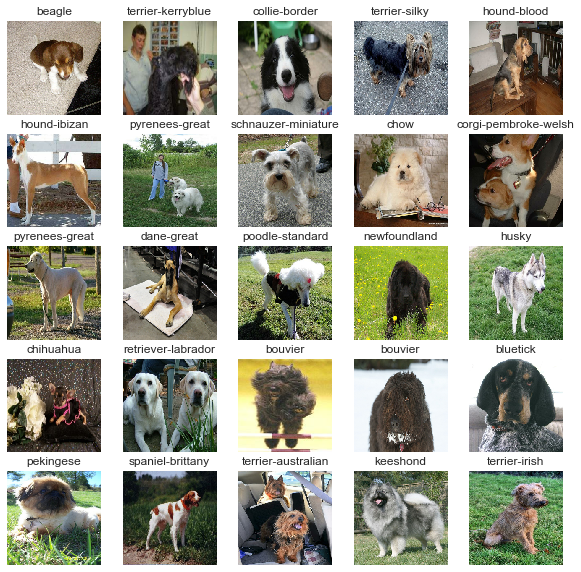

In [28]:
### Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

***

## 3: Baseline Model - Dummy Classifier

In order for my succeeding models to have a baseline where it can compare its scores against, I need to create a baseline model based on dummy classifiers. This baseline model will not generate any insight about the data and classifies the given data using only simple rules. The classifier’s behavior is completely independent of the training data as the trends in the training data are completely ignored and instead uses one of the strategies to predict the class label.

The strategies I will be using are as follows. Then I will get the best-scoring strategy as the official baseline model. 
* **Most Frequent** - Always predicts the most frequent class label in the training data (in this case, it is Maltese)
* **Stratified** - Generates predictions by respecting the class distribution of the training data
* **Uniform** - Generates predictions uniformly at random
* **Constant** - Always predicts a constant label (non-majority)

In [139]:
### This code blocks prepares the prediction to always be maltese, the most frequent class

most_freq_train = []
most_freq_test = []

i = 0
while i < len(valid_files):
    most_freq_test.append([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
    i += 1
    
i = 0
while i < len(train_files):
    most_freq_train.append([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
    i += 1    

In [143]:
def baseline_model(model, name):
    '''
    This function runs a dummy classifier and outputs the scores
    based on each dummy strategy.
    
    Parameters:
    - model = dummy model
    - name = dummy model name
    
    Returns:
    - List of dummy model scores
    
    '''
    print(name)
    print('-'*20)
    
    if strategy == 'most_frequent':
            
        print('Training Performance')
        print('-> Acc:', accuracy_score(train_targets, most_freq_train) )
    
        print('Testing Performance')
        print('-> Acc:', accuracy_score(valid_targets, most_freq_test) )
        print()
    
    else:
        print('Training Performance')
        print('-> Acc:', accuracy_score(train_targets, model.predict(train_files)) )
    
        print('Testing Performance')
        print('-> Acc:', accuracy_score(valid_targets, model.predict(valid_files)) )
        print()

In [145]:
### Run function above
for strategy in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(train_files, train_targets)
    judge_model(dummy, 'Dummy {}'.format(strategy))

Dummy stratified
--------------------
Training Performance
-> Acc: 0.0028566808602382364
Testing Performance
-> Acc: 0.0016245068461359943

Dummy most_frequent
--------------------
Training Performance
-> Acc: 0.01088772705222875
Testing Performance
-> Acc: 0.010907403109770248

Dummy prior
--------------------
Training Performance
-> Acc: 0.0
Testing Performance
-> Acc: 0.0

Dummy uniform
--------------------
Training Performance
-> Acc: 0.0
Testing Performance
-> Acc: 0.0



#### Observations:

Out of the four strategies, it is clear that **most_frequent is the best performing baseline model**. Thus I will set it as the official baseline model for comparison purposes. Nevertheless, it is very important to mention that even though most_frequest performed best, its results are dismal! This only means that I predicted the Maltese to all images which resulted to an accuracy of a measly **1.1%**. This makes sense because we have 28,000+ images and 173 classes. Blind predictions will be close to useless.

***

## 4: CNN Model from Scratch

This section is where I attempt to build a CNN model from scratch. My target is to achieve an accuracy score higher than 1.1% (the baseline model score) and .6% (random guessing 1/173 classes). Otherwise, the model will be more useless than merely predicting the most frequent class or by pure random guess.

I need to be careful in adding too many trainable layers because more parameters means longer training.

### Model Parameters

Here is the outline of the steps I took to get to the CNN architecture.
* 3 convolutional layers are created with 3 max pooling layers in between them to learn hierarchy of high level features. Max pooling layer is added to reduce the dimensionality.
* I was supposed to use Flatten layer to reduce the matrix to row vector but in the interest of time, I used GAP. 
* Filters were used 16, 32, 64 in each of the convolutional layers.
* Dropout was used along with flattening layer before using the fully connected layer to reduce overfitting and ensure that the network generalizes well.
* Number of nodes in the last fully connected layer were setup as 173 along with softmax activation function to obtain probabilities of the prediction.
* Relu activation function was used for all other layers.

In [39]:
### Model architecture

model = Sequential()

### CNN
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D(input_shape=(28,28,64)))
model.add(Dropout(0.15))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(173, activation='softmax'))

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)               

### Compile the Model

The optimizer is Adam because it performs generally well in most models. Other possible optimizers would be RMSprop and Stochastic Gradient Descent.

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Fit and Train the Model

I set the number of epochs to 30 to avoid overfitting. I also ensured that the best model out of all epochs will be saved by using checkpointer.

In [42]:
### Number of epochs
epochs = 30

### Fit and train
checkpointer = ModelCheckpoint(filepath='models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 18553 samples, validate on 4309 samples
Epoch 1/30
18553/18553 [==============================] - 349s 19ms/step - loss: 5.0484 - accuracy: 0.0084 - val_loss: 5.0054 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 5.00538, saving model to models/weights.best.from_scratch.hdf5
Epoch 2/30
18553/18553 [==============================] - 331s 18ms/step - loss: 4.9585 - accuracy: 0.0161 - val_loss: 4.9094 - val_accuracy: 0.0181

Epoch 00002: val_loss improved from 5.00538 to 4.90941, saving model to models/weights.best.from_scratch.hdf5
Epoch 3/30
18553/18553 [==============================] - 322s 17ms/step - loss: 4.8851 - accuracy: 0.0220 - val_loss: 4.8518 - val_accuracy: 0.0246

Epoch 00003: val_loss improved from 4.90941 to 4.85185, saving model to models/weights.best.from_scratch.hdf5
Epoch 4/30
18553/18553 [==============================] - 321s 17ms/step - loss: 4.8035 - accuracy: 0.0282 - val_loss: 4.7610 - val_accuracy: 0.0334

Epoch 00004: val_loss imp

### Model Evaluation

In [43]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.3828%


To functions below plots accuracy and loss of the models that I will be running in this notebook.

In [41]:
def plot_accuracy(model_fit):
    # Get training and test accuracy histories
    training_accuracy = model_fit.history['accuracy']
    test_accuracy = model_fit.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_accuracy) + 1)

    # Visualize accuracy history
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    return plt.show();

In [42]:
def plot_loss(model_fit):
    training_loss = model_fit.history['loss']
    test_loss = model_fit.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    return plt.show();

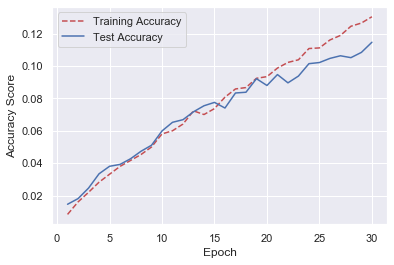

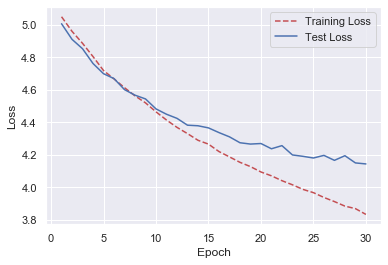

(None, None)

In [47]:
plot_accuracy(history), plot_loss(history)

#### Observations:

It is good to see that the CNN model built from scratch performed significantly better than the baseline mode. This suggests that the model has learned some patterns in the dataset that led to correct predictions. However, the accuracy of 11% is still abysmal and is not a good model to predict dog breeds.

Remember in the EDA notebook, there was apparent class imbalance where many of the breeds has only fewer than 50 images available for training. Some resources even suggest that for a model to be successful, it would need to have at least 1,000 images for each class. If I do collect that, we're talking about 173,000 images! We do not have time to complete that many collection and our current available resources might not even be able to train the models using that many data.

So it seems that I am stuck with the number of classes and images that I have thus far. One option is to reduce the number of classes by focusing on a small subset of breeds. But I do not want to do that because I truly believe in the social impact that might project can bring so I want to include as many breeds as possible.

Fortunately, we have a solution! Instead of collecting more and more images and meticulously fine tune our parameters, we can use Transfer Learning instead. Why reinvent the wheel?

Transfer learning provides us with pre-trained models that may have encountered countless of other dog images before. We will tap into what these pre-trained models have learned before and use them to our advantage.

***

## 5: Transfer Learning - Model 1

As discussed above, why waste time in collecting more images and fine-tuning models from scratch when there are pre-trained models available through Transfer Learning. Building a machine learning model and training it on lots from scratch can be expensive and time consuming. Transfer learning helps alleviate some of these by taking what another model has learned and using that information with your own problem.

I will be using pre-trained models from TensorFlow Hub. 

For this model, I will be using mobilenet v2.

### Model Build

Before I can build a model using transfer learning, there are three things I need to define:
* Input shape 
* Output shape
* URL of the model I will be using

Note that I will again be saving the model from the best performing epoch using ModelCheckpoint.

In [31]:
### Setup input shape to the model (batch, size, size, color channels)
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

### Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) 

### Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

### Save best model
checkpointer = ModelCheckpoint(filepath='models/weights.best.mobilenet.hdf5', 
                               verbose=1, save_best_only=True)

Now that I have all the inputs needed, I will create a function that takes in all of the inputs specified, then will define the layes in a Keras model sequentially. The function will then complete the model then builds it.

I will be using a sequential model instead of functional to make it simple and efficient. Softmax is used as activation because this is a multi-class problem and it provides me with prediction probabilities to each breed based on a given image.

Again, I will be using a generally well-accepted Adam optimizer. 

In [32]:
### Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    '''
    This function gets the inputs parameters then builds a Keras model.
    
    Parameters:
    - input_shape = images in tensor format
    - output_shape = image labels in tensor format
    - model_url = location of the model we will want to reuse
    
    Output:
    - Set up, compiled and built model
    
    '''
    print("Building model with:", MODEL_URL)

    ### Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), 
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax")
    ])

    ### Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(), 
        optimizer=tf.keras.optimizers.Adam(), 
        metrics=["accuracy"] 
    )

    ### Build the model
    model.build(INPUT_SHAPE) 
  
    return model

In [33]:
### Create a model using the function and check the details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  173346    
Total params: 5,606,059
Trainable params: 173,346
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating Callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving. I will be using three callbacks in this model.
* **TensorBoard** - visual way to monitor progress during and after training
* **Early Stopping** - to avoid overfitting by stopping the model when a certain evaluation metrics stops improving
* **Checkpointer** - saves the best model

In [34]:
### Load the TensorBoard notebook extension
%load_ext tensorboard

In [35]:
### Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    '''
    Create tensorboard as logs. 
    
    Parameters:
    - None
    
    Output:
    - Logs
    
    '''
  ### Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs/",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [36]:
### Create early stopping that stops after 3 no improvement rounds
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3)

In [37]:
### How many rounds should we get the model to look through the data?
NUM_EPOCHS = 40

### Model Training

This is where we actually train the model.

In [38]:
# Build a function to train and return a trained model
def train_model():
  '''
  Trains a given model and returns the trained version.
  
  Parameters:
  - None
  
  Output:
  - Trained model
  '''

    #### Create a model
    model = create_model()

    ### Create new TensorBoard session
    tensorboard = create_tensorboard_callback()

    ### Fit the model to the data passing it the callbacks 
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping, checkpointer])
  
    return model

In [39]:
### Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 500 steps, validate for 125 steps
Epoch 1/40
499/500 [============================>.] - ETA: 0s - loss: 0.8144 - accuracy: 0.7916
Epoch 00001: val_loss improved from inf to 0.45669, saving model to models/weights.best.mobilenet.hdf5
500/500 [==============================] - 399s 799ms/step - loss: 0.8134 - accuracy: 0.7918 - val_loss: 0.4567 - val_accuracy: 0.8597
Epoch 2/40
499/500 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.9138
Epoch 00002: val_loss did not improve from 0.45669
500/500 [==============================] - 393s 787ms/step - loss: 0.2723 - accuracy: 0.9136 - val_loss: 0.4665 - val_accuracy: 0.8565
Epoch 3/40
499/500 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9480
Epoch 00003: val_loss did not improve from 0.45669
500/500 [==============================] - 395s 790ms/step - loss: 0.1746 - accuracy: 0.9478 - val_l

### Model Evaluation

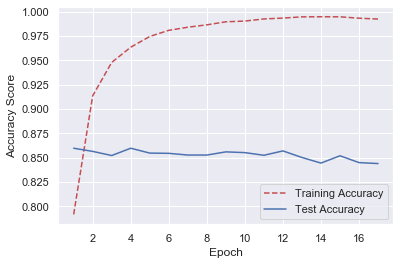

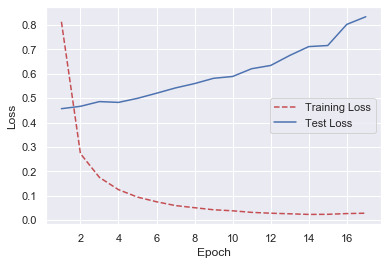

(None, None)

In [43]:
plot_accuracy(model.history), plot_loss(model.history)

In [73]:
model_mobilenet.evaluate(val_data)

125/125 [==============================] - 102s 815ms/step - loss: 0.4567 - accuracy: 0.8597


[0.45668970131874087, 0.85975]

#### Observations:

The best model out of all the rounds of training resulted to an accuracy of 86%, which is a tremendous improvement from our baseline models and even the model built from scratch. This proves the effectiveness of transfer learning where we just reuse pre-trained models. It does not even cost me anything to use them. 

With this results, I can honestly say that I am now confident in predicting dog breeds based on an image. 

I will later analyze the usual mistakes in prediction but I believe those false predictions are due to really similar looking breeds. I will find out later.

***

## 6: Transfer Learning - Model 2

Now that I have proven the significant advantages of using a pre-trained model, we might as well try another one and check if it performs better than mobile net. This time, I will use Inception Resnet model. According to a study, the model has been shown to achieve very good performance at relatively low computational cost.

You will observe below that running a suceeding pre-trained model will be fairly straightforward because we have already created reusable function sin the first model. It is now easier to try and try other models.

### Model Build

Similar to the first model, we need to input the needed parameters.

In [44]:
### Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

### Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) 

### Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"


checkpointer = ModelCheckpoint(filepath='models/weights.best.inception_resnet.hdf5', 
                               verbose=1, save_best_only=True)

In [45]:
### Create a model and check the details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  55875273  
_________________________________________________________________
dense_2 (Dense)              multiple                  173346    
Total params: 56,048,619
Trainable params: 173,346
Non-trainable params: 55,875,273
_________________________________________________________________


### Model Training

In [46]:
### Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4
Train for 500 steps, validate for 125 steps
Epoch 1/40
499/500 [============================>.] - ETA: 2s - loss: 0.6321 - accuracy: 0.8573
Epoch 00001: val_loss improved from inf to 0.53520, saving model to models/weights.best.inception_resnet.hdf5
500/500 [==============================] - 1571s 3s/step - loss: 0.6318 - accuracy: 0.8572 - val_loss: 0.5352 - val_accuracy: 0.8790
Epoch 2/40
499/500 [============================>.] - ETA: 2s - loss: 0.3596 - accuracy: 0.9005
Epoch 00002: val_loss did not improve from 0.53520
500/500 [==============================] - 1372s 3s/step - loss: 0.3596 - accuracy: 0.9006 - val_loss: 0.5777 - val_accuracy: 0.8695
Epoch 3/40
499/500 [============================>.] - ETA: 2s - loss: 0.2956 - accuracy: 0.9126
Epoch 00003: val_loss did not improve from 0.53520
500/500 [==============================] - 1357s 3s/step - loss: 0.2967 - accuracy: 0.9124 - val_l

Epoch 30/40
499/500 [============================>.] - ETA: 2s - loss: 0.0686 - accuracy: 0.9770
Epoch 00030: val_loss did not improve from 0.53520
500/500 [==============================] - 1374s 3s/step - loss: 0.0686 - accuracy: 0.9769 - val_loss: 1.0807 - val_accuracy: 0.8800
Epoch 31/40
499/500 [============================>.] - ETA: 2s - loss: 0.0757 - accuracy: 0.9736
Epoch 00031: val_loss did not improve from 0.53520
500/500 [==============================] - 1408s 3s/step - loss: 0.0757 - accuracy: 0.9736 - val_loss: 1.0607 - val_accuracy: 0.8748
Epoch 32/40
499/500 [============================>.] - ETA: 2s - loss: 0.0771 - accuracy: 0.9734
Epoch 00032: val_loss did not improve from 0.53520
500/500 [==============================] - 1427s 3s/step - loss: 0.0769 - accuracy: 0.9734 - val_loss: 1.1279 - val_accuracy: 0.8712
Epoch 33/40
499/500 [============================>.] - ETA: 2s - loss: 0.0772 - accuracy: 0.9745
Epoch 00033: val_loss did not improve from 0.53520
500/500 [

### Model Evaluation

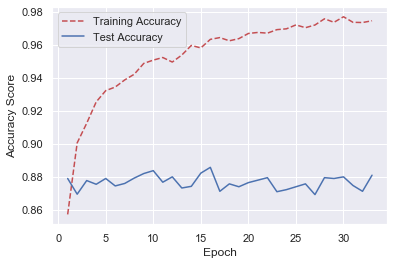

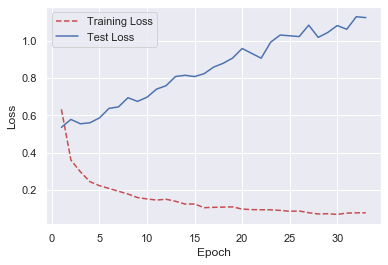

(None, None)

In [47]:
plot_accuracy(model.history), plot_loss(model.history)

In [71]:
# Evaluate the pre-saved model
model_resnet.evaluate(val_data)

125/125 [==============================] - 341s 3s/step - loss: 0.5352 - accuracy: 0.8790


[0.535201402850449, 0.879]

#### Observations:

The previous transfer learning model improved even further from 86% to 88%, thereby further increasing my confidence with the model as well. Again, I will deep-dive into the mis-classifications to confirm whether these breeds really look similar.

***

## 7: Saved Model Loading

This part tackles loading the saved models from the checkpointer that I have created.

In [29]:
def load_model(model_path):
    '''
    Loads a saved model from a specified path.
    
    Parameter:
    - model path = location of the saved .hdf5 model
    
    Returns:
    - Loaded model
    
    '''
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
    return model

***

## 8: Best Model Selection

This is where I will select the overall best model out of all the different models we ran. To do this, I will load each of the saved models then choose the one with the highest accuracy. I am using accuracy as my final metric because I am not handling sensitive data like medical decisions where the balance between precision and recall matters. I will simply look at accuracy to check whether the model has correctly predicted a breed. 

### Model from Scratch

In [67]:
# Load our model trained on 1000 images
model_scratch = load_model('models/weights.best.from_scratch.hdf5')

Loading saved model from: models/weights.best.from_scratch.hdf5


In [68]:
# Evaluate the pre-saved model
model_scratch.evaluate(val_data)

125/125 [==============================] - 28s 220ms/step - loss: 3.7251 - accuracy: 0.1643


[3.7251318740844725, 0.16425]

### Transfer Learning 1 - Mobile Net

In [72]:
# Load our model trained on 1000 images
model_mobilenet = load_model('models/weights.best.mobilenet.hdf5')

Loading saved model from: models/weights.best.mobilenet.hdf5


In [73]:
model_mobilenet.evaluate(val_data)

125/125 [==============================] - 102s 815ms/step - loss: 0.4567 - accuracy: 0.8597


[0.45668970131874087, 0.85975]

### Transfer Learning 2 - Inception Resnet

In [30]:
# Load our model trained on 1000 images
model_resnet = load_model('models/weights.best.inception_resnet.hdf5')

Loading saved model from: models/weights.best.inception_resnet.hdf5


In [71]:
# Evaluate the pre-saved model
model_resnet.evaluate(val_data)

125/125 [==============================] - 341s 3s/step - loss: 0.5352 - accuracy: 0.8790


[0.535201402850449, 0.879]

#### Observations:

It is clear that the best overall model is Transfer Learning model #2 - Inception Resnet. I will use this particular model to make predictions and to check mis-classifications.

***

## 8: Making Predictions

Now it's time to see the model in action.

### Predictions on Validation Data

In [48]:
### Make predictions on the validation data (not used to train on)
predictions = model_resnet.predict(val_data, verbose=1)
predictions

180/180 [==============================] - 414s 2s/step


array([[5.5393131e-05, 3.5680805e-06, 7.3580122e-07, ..., 1.1423379e-07,
        2.0995467e-05, 1.1056545e-05],
       [1.0160850e-05, 5.2829620e-07, 3.4071945e-07, ..., 3.7924440e-07,
        1.9523617e-07, 1.2343013e-06],
       [3.4793022e-06, 1.3254897e-06, 1.1727581e-07, ..., 6.7475696e-08,
        1.9515294e-06, 6.9599048e-07],
       ...,
       [3.3168192e-08, 9.2319590e-07, 6.6655241e-07, ..., 9.1596257e-07,
        5.0862195e-06, 1.3497937e-06],
       [5.3853523e-06, 2.0372765e-06, 3.2101596e-07, ..., 1.5337740e-07,
        2.6936959e-05, 1.0152578e-08],
       [1.9356506e-08, 1.8651266e-07, 3.6116944e-08, ..., 5.4747098e-08,
        8.5376701e-07, 1.5683631e-06]], dtype=float32)

In [52]:
### Check the shape of predictions
predictions.shape

(4000, 173)

Making predictions returns an array with a different value for each label.

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

We need to convert an array of probabilities into an actual label.

In [53]:
### First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[6.07547487e-20 1.56913785e-14 1.74500273e-14 3.50363998e-14
 6.16559798e-12 1.15726571e-14 1.20785907e-14 5.53590160e-19
 8.89892814e-15 6.36028730e-11 4.31120140e-11 3.28798322e-10
 2.53707103e-14 1.44518674e-12 7.44918636e-15 3.60167273e-13
 2.73663888e-17 3.45164888e-15 1.15410760e-13 1.82248287e-14
 1.19364603e-14 1.35763650e-10 2.51647157e-15 9.39111273e-15
 2.98206555e-14 8.57120229e-14 8.40185838e-11 5.73526273e-16
 1.14012727e-12 5.59077849e-13 4.60328483e-15 9.07042775e-15
 3.83641652e-14 8.36551084e-15 1.20588886e-10 3.34920177e-18
 2.32737922e-14 7.98538481e-14 2.22301616e-15 4.12564973e-15
 2.45167897e-22 7.23538728e-14 6.22897187e-14 1.02661901e-14
 3.26651751e-14 2.97460658e-14 4.45472889e-14 1.92498459e-21
 4.85415473e-14 5.32172113e-16 1.37088615e-14 1.17116628e-14
 8.38487605e-14 1.66651502e-12 7.02647508e-14 5.68862596e-11
 4.62536029e-14 3.88765232e-23 6.94085360e-14 4.30385809e-14
 8.35744116e-15 3.57247928e-24 5.48979502e-15 1.28959745e-19
 2.09984482e-12 2.687386

I will create a function to convert prediction probabilities into predicted labels for easier understanding.

In [50]:
def get_pred_label(prediction_probabilities):
    '''
    Turns an array of prediction probabilities into a label.
    
    Parameters:
    - prediction probabilities
    
    Returns:
    - actual breed predicted
    '''  

    return unique_breeds[np.argmax(prediction_probabilities)]

### Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'spaniel-japanese'

Because the model has not trained on the validation data and rightfully so, we can use the validation images to visually compare the predictions with the actual breeds.

However, our validation data is still in batch format, we need to extract them once again.

In [55]:
def extract_batch(data):
    '''
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    
    Parameters:
    - data = batched dataset
    
    Returns
    - extracted images and labels
    '''
    
    images = []
    labels = []
  
    ### Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

### Extract the validation data
val_images, val_labels = extract_batch(val_data)
val_images[0], val_labels[0]

(array([[[0.51108193, 0.6365721 , 0.78951335],
         [0.51108193, 0.6365721 , 0.78951335],
         [0.51108193, 0.6365721 , 0.78951335],
         ...,
         [0.42808124, 0.4476891 , 0.4712185 ],
         [0.4387717 , 0.42094967, 0.43485013],
         [0.19884598, 0.22839801, 0.22689237]],
 
        [[0.50200456, 0.62749475, 0.7765144 ],
         [0.50200456, 0.62749475, 0.7765144 ],
         [0.50200456, 0.62749475, 0.7765144 ],
         ...,
         [0.42812502, 0.44773287, 0.47126228],
         [0.458328  , 0.4406306 , 0.45450062],
         [0.2121664 , 0.24183291, 0.2403171 ]],
 
        [[0.519319  , 0.6394346 , 0.7884542 ],
         [0.519319  , 0.6394346 , 0.7884542 ],
         [0.519319  , 0.6394346 , 0.7884542 ],
         ...,
         [0.4320028 , 0.45161065, 0.47514006],
         [0.42751274, 0.42354748, 0.44009155],
         [0.22995342, 0.2734836 , 0.2770661 ]],
 
        ...,
 
        [[0.6901961 , 0.6509804 , 0.5529412 ],
         [0.697444  , 0.65822834, 0.56018

It is always better to visualize results. I need a function that displays an image, its predicted label and the actual breed.

In [56]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    '''
    View the prediction, ground truth label and image for sample n.
    
    Parameters:
    - prediction probabilities
    - actual breeds
    - images
    - number
    
    Returns:
    - Display image and prediction
    '''
    
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
    ### Get the pred label
    pred_label = get_pred_label(pred_prob)
  
    ### Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    ### Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

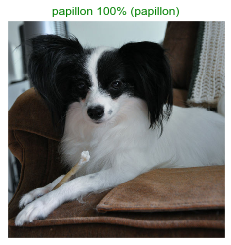

In [59]:
### View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

Since this is a multi-class classification problem, it is better to display the other predictions the model is making. This is particularly useful in analyzing the mis-classifications. 

In [60]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    '''
    Plots the top 10 highest prediction confidences along with
    the truth label for sample n.
    
    Parameters:
    - prediction probabilities
    - labels
    - number
    
    Returns:
    - top N predictions
    '''
  
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    ### Get the predicted label
    pred_label = get_pred_label(pred_prob)

    ### Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  
    ### Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]
  
    ### Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    ### Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

    ### Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

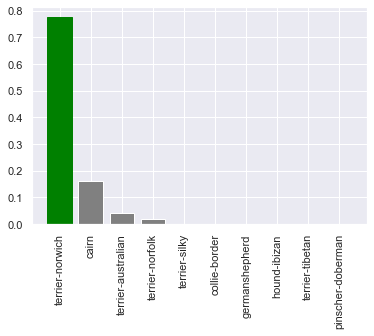

In [61]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Let's look at multiple predictions at a time given our large number of classes.

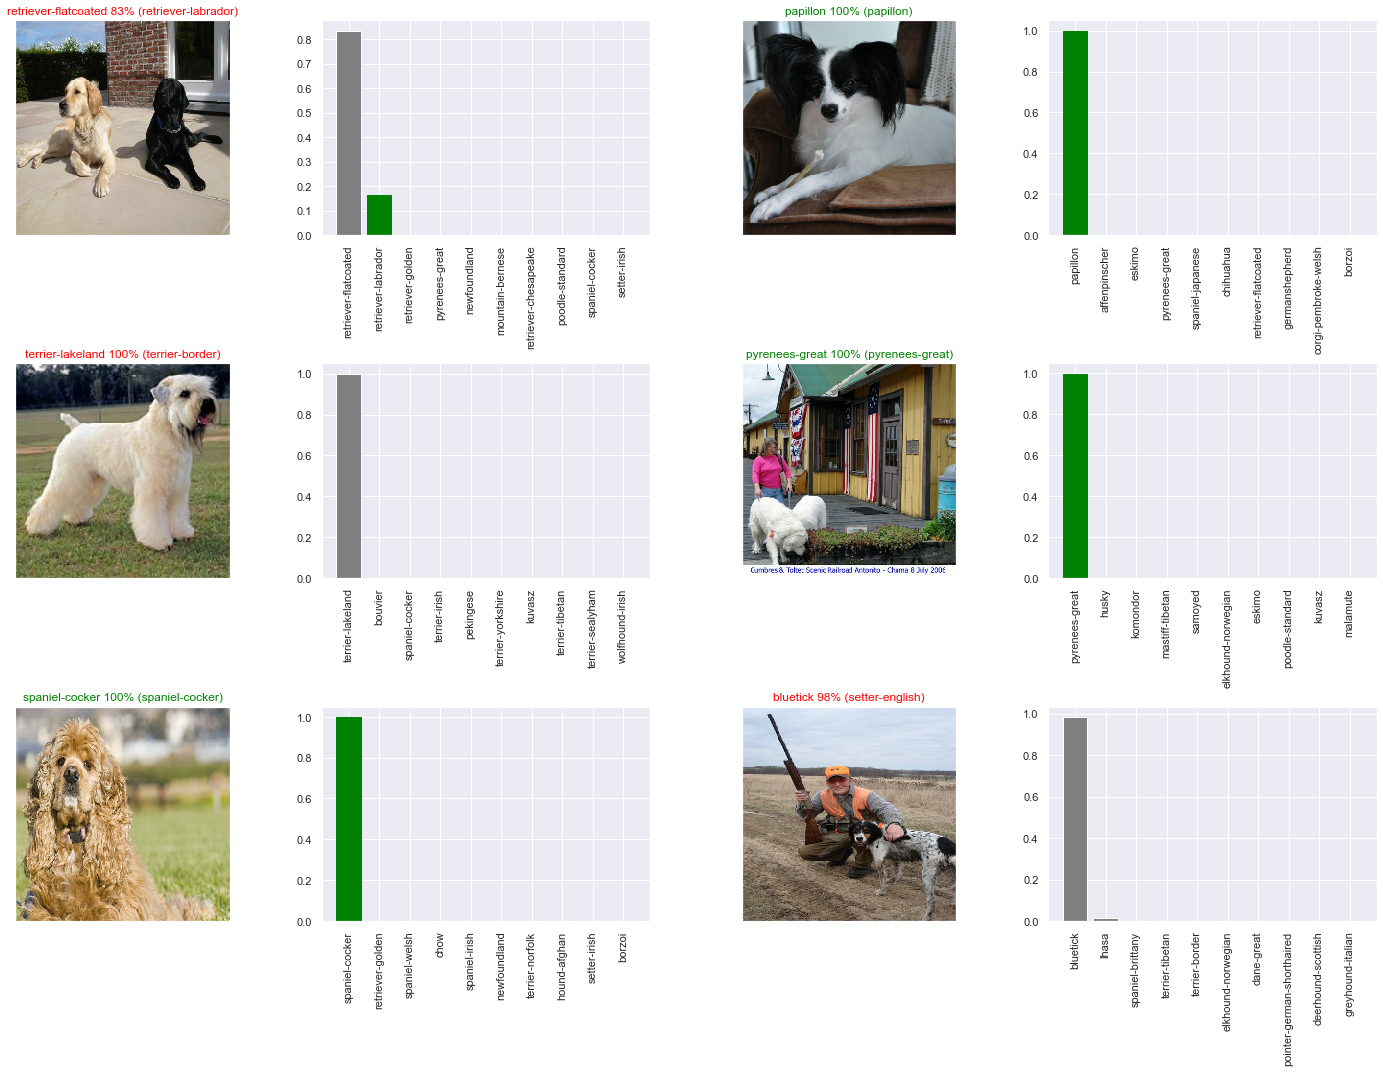

In [64]:
### Check several predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

#### Observations:

My theory proves to be correct. The mis-classifications that have happened are mostly due to very similar-looking breeds or breeds with distinct physical attributes.

1. Flatcoated Retriever versus Labrador Retriever
    * They look very, very similar


2. Bluetick versus English Setter
    * They both have irregular black patches in their fur

### Confusion Matrix

This section produces a confusion matrix, although this might be harder to interpret mainly because of the number of classes that we have. Nevertheless, false predictions can also be derived from here just by looking at the darker cells in the matrix aside from the main diagonal line which shows correct predictions.

In [52]:
preds = []
for prediction in predictions:
    preds.append(get_pred_label(prediction))
len(preds)

5734

In [56]:
tgts = []
for y in y_val:
        tgts.append(get_pred_label(y))
tgts

['spaniel-japanese',
 'terrier-american',
 'pug',
 'weimaraner',
 'kelpie',
 'schnauzer-miniature',
 'setter-english',
 'spaniel-sussex',
 'terrier-dandie',
 'husky',
 'lhasa',
 'bulldog-french',
 'terrier-bull',
 'charles-cavalier-king',
 'terrier-lakeland',
 'terrier-silky',
 'groenendael',
 'dingo',
 'chihuahua',
 'dhole',
 'spaniel-irish',
 'terrier-sealyham',
 'spaniel-irish',
 'xoloitzcuintli',
 'pinscher-miniature',
 'shihtzu',
 'spaniel-english-springer',
 'collie-border',
 'dingo',
 'retriever-labrador',
 'pomeranian',
 'hound-blood',
 'bouvier',
 'sheepdog-english',
 'terrier-sealyham',
 'griffon-wirehaired-pointing',
 'african',
 'malinois-belgian',
 'poodle-standard',
 'lhasa',
 'papillon',
 'kuvasz',
 'terrier-border',
 'deerhound-scottish',
 'tervuren-belgian',
 'dane-great',
 'malamute',
 'kelpie',
 'stbernard',
 'retriever-chesapeake',
 'plott',
 'elkhound-norwegian',
 'hound-afghan',
 'ridgeback-rhodesian',
 'entlebucher',
 'hound-ibizan',
 'schnauzer-giant',
 'pekinge

In [62]:
cm = confusion_matrix(tgts, preds)
classes = unique_breeds

In [70]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function automatically plots the confusion matrix.
    
    Parameter: 
        cm: confusion matrix from the scoring function
        normalize: True if to be normalized
        title: title of the confusion matrix
        cmap: plotting method
        
    Returns: 
        This returns a graphical confusion matrix
    '''
    plt.figure(figsize = (25,25))
    plt.imshow(cm,  cmap=cmap, aspect='auto') #Create the basic matrix.
    
    #Add title and Axis Labels
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(classes) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = cm.max() / 2. #Used for text coloring below

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    return plt.show()

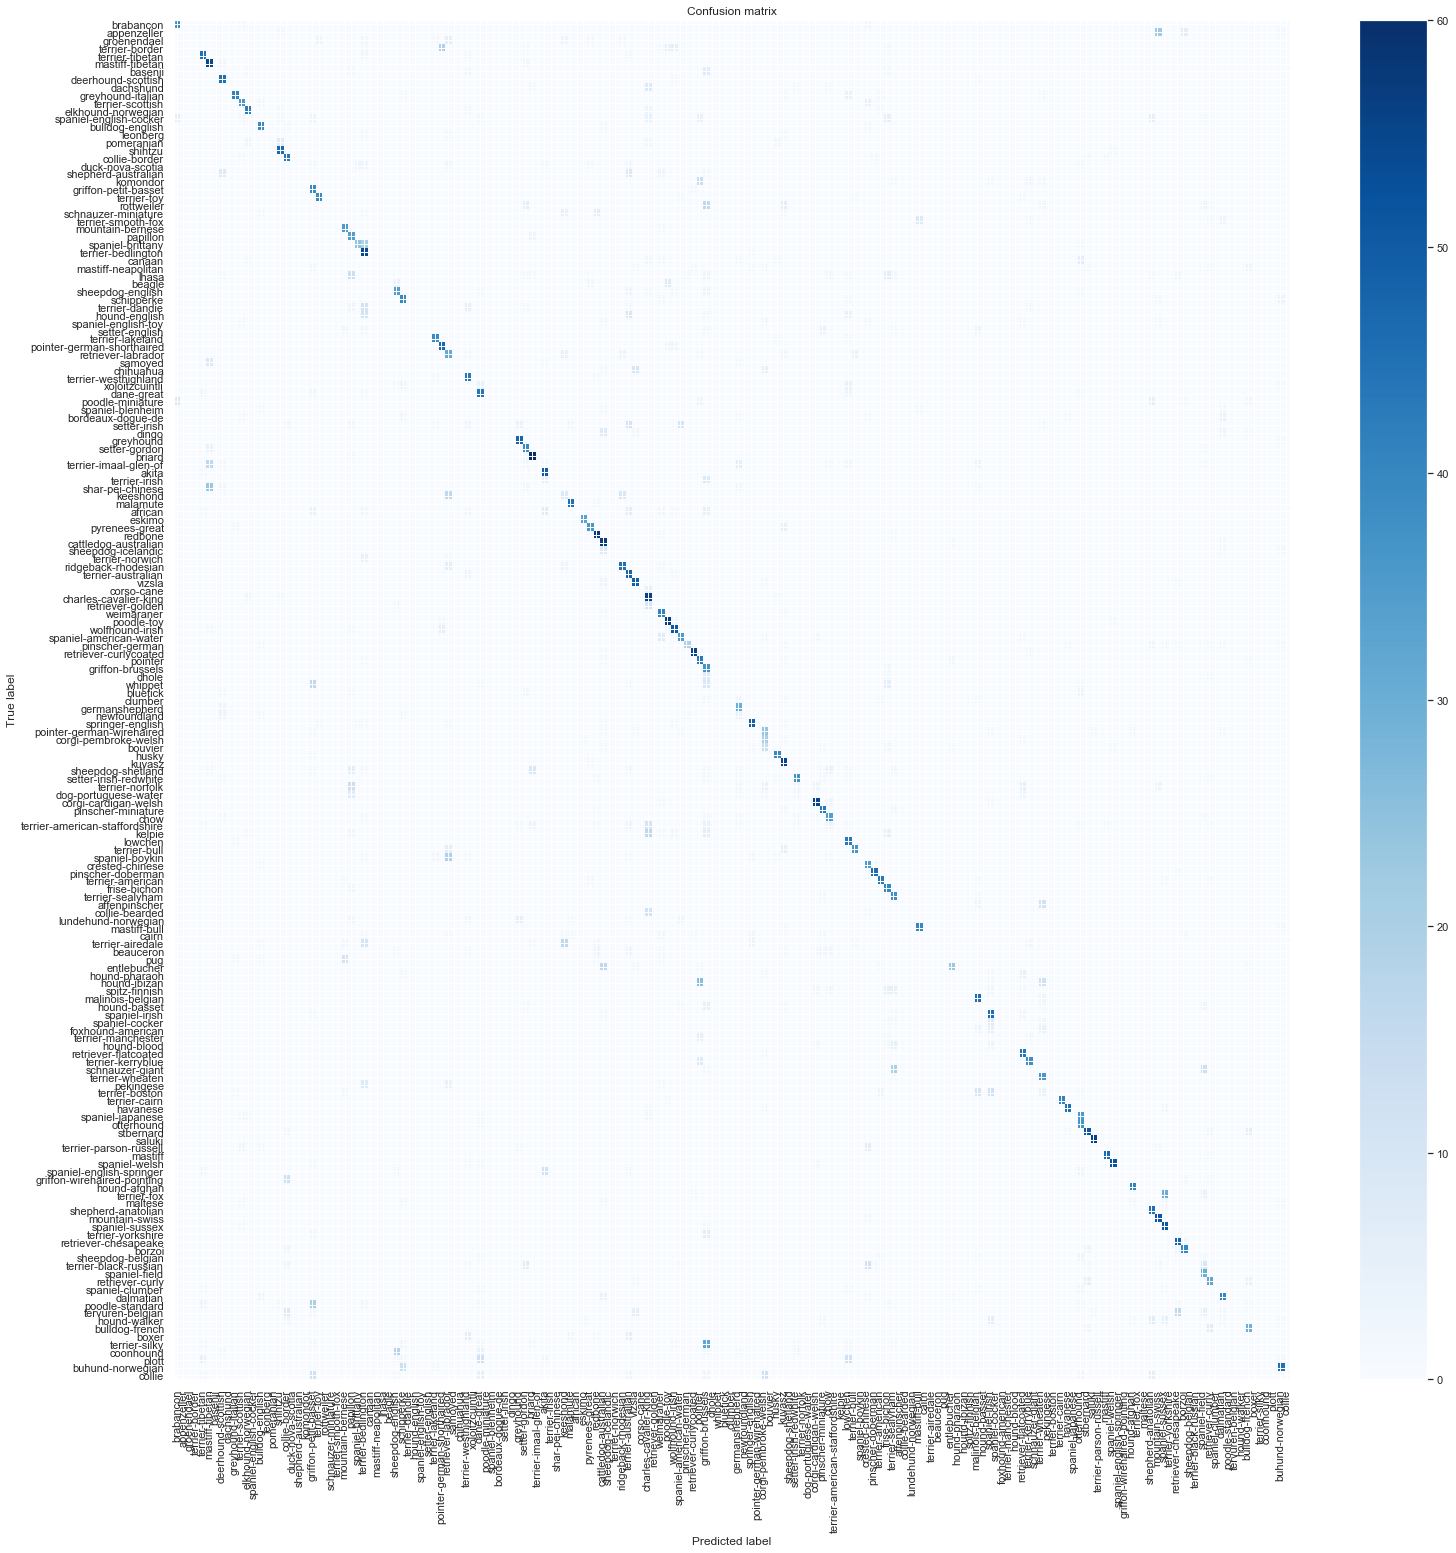

In [71]:
plot_confusion_matrix(cm, classes)

### Predicting Customer / User Images

It is great to make predictions on validation images, but it is even better to predict breeds based on user-uploaded and custom images. In this section, I will upload photos of my own dogs to check if the system can predict their breeds correctly.

In [107]:
### Get custom image filepaths
custom_path = "predict/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [108]:
### Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [109]:
### Make predictions on the custom data
custom_preds = model_resnet.predict(custom_data)

In [110]:
### Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['boxer', 'bulldog-french', 'boxer', 'malinois-belgian']

In [111]:
### Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
### Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

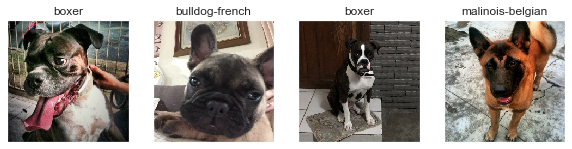

In [112]:
### Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

#### Observations:

There you go, the model has correctly predicted the breeds of two of my dogs. I suppose my model is ready for the next phase of the project which is to attach a recommendation engine into it.